## 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인

* 더 나은 성능을 위해 딥러닝 모델을 만들어 보겠다.
* 지난 이론 시간에 배웠던 딥러닝 모델링 기법을 적용해 실제로 학습을 수행해보겠다.
* 이번 단계에서는 대량의 눈동자 위치 라벨이 필요하다.
* 앞에서 만든 coarse dataset 또는 직접 어노테이션 한 라벨이 10,000개 이상 있어야 성능을 확인할 수 있다.
* 이전 스텝에서 다룬 눈동자 검출 방법을 LFW 데이터셋에 적용하여 필요한 만큼의 데이터셋을 생성해 보자.
* 데이터셋을 생성하는 코드 prepare_eye_dataset.py를 실행하면 아래 사용할 데이터셋이 LFW 데이터셋으로부터 가공 생성된다.
* 생성된 데이터셋은 ~/lfw/data/train, ~/lfw/data/valid 아래에서 확인할 수 있다.

In [1]:
# (주의) 아래 코드는 총 13000여 개의 LFW 데이터셋으로부터 데이터셋을 가공 생성하는 과정으로 20분 이상 소요될 수 있다.
# cd ~/aiffel/coarse_to_fine && python prepare_eye_dataset.py

## 0. 패키지 로딩하기

In [2]:
from PIL                        import Image
from tensorflow.keras           import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler

import os
import cv2
import glob
import math
import numpy             as np
import tensorflow        as tf
import tensorflow_hub    as hub
import matplotlib.pyplot as plt

## 1. 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인

* TensorFlow Hub에서 제공하는 pretrained image feature embedding을 가지고 fine tuning을 해보겠다.
* 가지고 있는 데이터를 케라스 ImageDataGenerator 형식으로 읽는다. 저는 라벨을 image 형태로 저장해 두었다.

In [3]:
home_dir   = os.getenv("HOME") + "/lfw"
list_image = sorted(glob.glob(home_dir + "/data/train/input/img/*.png"))
list_label = sorted(glob.glob(home_dir + "/data/train/label/mask/*.png"))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root   = home_dir + "/data/train/input"
label_root  = home_dir + "/data/train/label"

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()

image_data = image_generator.flow_from_directory(str(data_root),  class_mode = None, target_size = IMAGE_SHAPE, batch_size = 32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode = None, target_size = IMAGE_SHAPE, batch_size = 32)

23712 23712
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


* train 데이터셋이 23,712쌍, val 데이터셋이 2,638쌍 생성되었다.
* (참고) 경우에 따라서는 train 데이터셋의 갯수가 23,712쌍과 다르게 만들어질 수 있다. batch_size 32의 배수인 23,712쌍과 같아지도록 이미지 데이터의 갯수를 맞춰주도록 한다. 32의 배수 조건만 만족하면 된다.

* 아래 코드에서는 image_generator, label generator를 학습할 수 있는 입출력 형식으로 편집한다.
* 텐서플로우의 제너레이터(generator) 형식을 사용하고 있기 때문에 출력 형식도 맞추어 주겠다.

* 학습 라벨을 만들 때 3개의 점을 label 이미지에 표시했다.
* 눈의 왼쪽 끝점을 1의 값으로, 오른쪽 끝점은 2의 값으로, 가장 중요한 눈 중심(눈동자)는 3으로 인코딩 했다.
* np.where() 함수로 이미지에서 좌표로 복원한다.

In [4]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images  = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        
        for img, label in zip(images, labels):
            eye_ls     = np.where(label == 1) # left  side
            eye_rs     = np.where(label == 2) # right side
            eye_center = np.where(label == 3) # center

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0]) == 0 or len(eye_ls[1]) == 0:
                lx, ly = [0, 0]
            if len(eye_rs[0]) == 0 or len(eye_rs[1]) == 0:
                rx, ry = [w, h]
            if len(eye_center[0]) == 0 or len(eye_center[1]) == 0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx / w, ly / h, rx / w, ry / h, cx / w, cy / h], dtype = np.float32)
            list_point_labels.append(np_point_label)
            
        np_point_labels = np.array(list_point_labels)
        
        yield (images, np_point_labels)

* (질문) 좌표로 복원할 때 eye_ls[1].mean() 으로 평균값을 구했다. 왜 그랬을까? 어떤 장점을 활용하려고 한 걸까?
* (대답)
* 1. 눈 크기가 이미지마다 사람마다 다르기 때문에 반드시 resize를 해야 한다.
* 2. 이 때 라벨을 이미지에 하나의 점으로 표현하면 resize 과정에서 소실될 수 있다.
* 3. 이런 단점을 극복하기 위해 라벨 이미지를 만들 때 gaussian smoothing을 적용해서 변화에 유연하게 대응할 수 있도록 했다.
* 4. 이 방법을 취하면 이후 augmentation을 구현할 때도 추가적인 노력없이 바로 라벨을 사용할 수 있다.

* 만들어진 제너레이터로 데이터 포인트를 뽑아 관찰한다.

In [5]:
user_train_generator = user_generation(image_data, label_data)

for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.54887253 0.31729412]
(80, 120, 3) [0.         0.         1.         1.         0.58059275 0.40820312]


/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()


## 2. 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계

* 데이터가 준비되었으니 이제 네트워크를 디자인한다.
* 우리는 데이터가 없는 상황이기 때문에 미리 학습된 모델을 적극적으로 활용해야 한다.
* TensorFlow Hub에서 ResNet의 특성추출기 부분을 백본(backbone)으로 사용하겠다.
* tf.keras.Sequential()을 이용해서 백본 네트워크와 fully connected layer를 쌓아서 아주 쉽게 모델을 완성할 수 있다.
* 데이터 제너레이터를 만들 때 출력을 6개((x, y) 좌표 2개 * 점 3개)로 했기 때문에 num_classes는 6으로 설정한다.

In [6]:
#  tf hub feature_extractor
feature_extractor_url   = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape = (80, 120, 3))

image_batch   = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = "sigmoid")
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 25,669,126
Trainable params: 2,104,326
Non-trainable params: 23,564,800
_________________________________________________________________


* 이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 loss와 metric을 각각 mse 와 mae 로 설정했다. mae 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습할 수 있다.

In [7]:
model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss      = "mse",
  metrics   = ["mae"]
)

* 학습률(learning rate)을 조절하는 함수도 제작한다.
* 아래 코드는 학습률을 지수적으로 감소하게 만들었다.

In [8]:
def lr_step_decay(epoch):
    init_lr         = 0.0005 #self.flag.initial_learning_rate
    lr_decay        = 0.5    #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2      #self.flag.epoch_per_decay
    lrate           = init_lr * math.pow(lr_decay, math.floor((1 + epoch) / epoch_per_decay))
    
    return lrate

* 학습을 진행한다.

In [9]:
steps_per_epoch = image_data.samples // image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32)의 배수로 맞춰 준비한다. 

# 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생한다.
assert(image_data.samples % image_data.batch_size == 0) 

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator,
                    epochs          = 10,
                    steps_per_epoch = steps_per_epoch,
                    callbacks       = [learning_rate]
                   )
# epochs가 10인 이유는 epochs = 20을 해본 결과 대략 7부터는 이후 학습이 효과가 없다.

23712 32 741
Epoch 1/10


/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()


741/741 [==============================] - 16s 22ms/step - loss: 0.0192 - mae: 0.0652
Epoch 2/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0126 - mae: 0.0521
Epoch 3/10
741/741 [==============================] - 16s 22ms/step - loss: 0.0125 - mae: 0.0516
Epoch 4/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0124 - mae: 0.0512
Epoch 5/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0124 - mae: 0.0510
Epoch 6/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0123 - mae: 0.0509
Epoch 7/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0123 - mae: 0.0509
Epoch 8/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0123 - mae: 0.0508
Epoch 9/10
741/741 [==============================] - 16s 22ms/step - loss: 0.0123 - mae: 0.0507
Epoch 10/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0123 - mae: 0.0508


## 3. 키포인트 검출 딥러닝 모델 만들기 (3) 평가

* 검증(validation)용 데이터는 섞어줄(shuffle) 필요가 없기 때문에 shuffle = False 옵션을 추가했다.

In [10]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv("HOME") + "/lfw"

val_data_root  = home_dir + "/data/val/input"
val_label_root = home_dir + "/data/val/label"

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()

image_data_val = image_generator.flow_from_directory(str(val_data_root),  class_mode = None, target_size = IMAGE_SHAPE, shuffle = False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode = None, target_size = IMAGE_SHAPE, shuffle = False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


* 제너레이터를 만들고 evaluate_generator() 로 평가를 수행한다.

In [11]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae           = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print("mse :", mse)
print("mae :", mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()


mse : 0.012308478355407715
mae : 0.050681982189416885


* 실제로 이미지에 출력해보겠다.

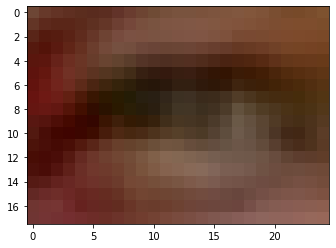

In [12]:
# img test
img = cv2.imread(val_data_root + "/img/eye_000010_l.png")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

* 입력을 위해 이미지를 120x80 으로 resize 한 후, 배치(batch)를 나타낼 수 있는 4차원 텐서로 변경한다.
* 우선 이미지 1장에 대해서 출력을 하려 하니 지금은 배치 크기(batch size)를 1로 만들면 된다.

In [13]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis = 0)
preds     = model.predict(np_inputs / 255., 1)

repred = preds.reshape((1, 3, 2))

repred[:,:,0] *= 120
repred[:,:,1] *= 80

print (repred)

[[[1.87923312e-02 8.46370868e-03]
  [1.19990814e+02 7.99900513e+01]
  [5.35370598e+01 2.72656288e+01]]]


* 출력결과를 뽑아보면 아래와 같이 나온다.
* 1행부터 좌측, 우측, 중앙 좌표를 나타낸다.
* 결과를 이미지에 출력해 보자.
* pt 값은 120x80 으로 뽑았는데 우리가 사용하는 데이터 크기는 60x40 이다.
* 따라서 pt 에 0.5 를 곱해서 그림에 출력한다.
* (주의) pt값을 뽑을때의 이미지 크기 기준(120X80)은 고정이지만, 사용하는 데이터의 크기는 매번 달라진다. 보정치 설정에 유의해야 한다.

[0. 0.]
[120.  80.]
[54. 27.]


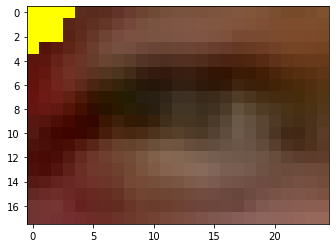

In [14]:
show = img.copy()

for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt * 0.55).astype(int)), 3, (0, 255, 255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 프로젝트: 카메라 앱에 당황한 표정 효과를 적용해보기

* 아래의 그림처럼 놀라서 눈이 튀어나오는 듯 한 효과를 내보자.
* 우선 눈을 찾고, 눈에 효과를 적용해보자.
* 어려워 보여도 차근차근 한다면 충분히 간단한 프로토타입을 구현하실 수 있다.

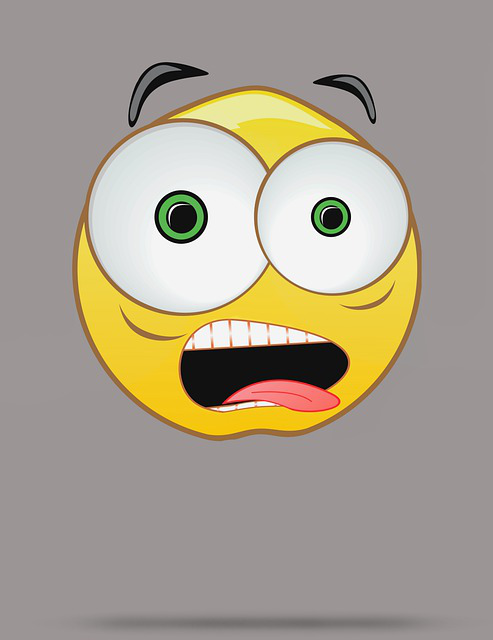

In [16]:
Image.open(os.getenv("HOME") + "/aiffel/coarse_to_fine/data/image.jpg")

### 4_1. 이론 시간에 다룬 모델을 참고하여 딥러닝 모델을 설계해 봅시다.

* 위 스텝에서 키포인트 검출을 위한 딥러닝 모델을 만들었다.
* 이를 활용해서 눈 이미지에서 적합한 키포인트를 찾는 딥러닝 모델을 구현해보자.
* 이 모델의 학습을 위해서는 노드에서 다룬 것처럼 데이터를 모아 데이터셋을 구축하는 과정이 함께 진행되어야 할 것이다.

In [17]:
# 위 과정은 오늘 노드에서 한 과정을 통해 이미 끝났다고 본다.

### 4_2. 눈동자 효과를 추가해 봅시다.

* 추출된 눈 위치에 위의 당황한 표정의 눈 이미지를 합성해 보자.
* 이렇게 합성된 이미지를 제출하는 것까지가 오늘 프로젝트 과제의 목표이다.

In [18]:
# lfw에서 아무리 찾아봐도 화질이 괜찮은 눈 이미지를 찾기가 어렵다.
# 따라서 눈동자 초점을 맞춘 이미지를 통해서 눈을 찾고 합성하기로 했다.

In [19]:
img_path = os.getenv("HOME") + "/aiffel/coarse_to_fine/data"
img_path

'/home/aiffel-dj52/aiffel/coarse_to_fine/data'

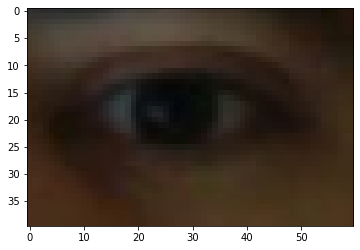

In [20]:
# img test
img = cv2.imread(img_path + "/eye.png")
img = cv2.resize(img, (60, 40)) # 위에 코드를 그대로 쓰기 위한 resize

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis = 0)
preds     = model.predict(np_inputs / 255., 1)

repred = preds.reshape((1, 3, 2))

repred[:,:,0] *= 120
repred[:,:,1] *= 80

print (repred)

[[[8.2605826e-03 2.6112213e-03]
  [1.1999423e+02 7.9994568e+01]
  [5.3611629e+01 2.7154819e+01]]]


[0. 0.]
[120.  80.]
[54. 27.]


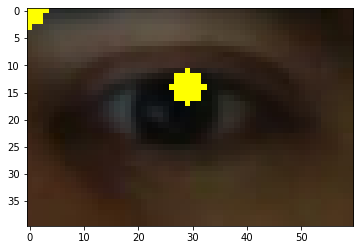

In [22]:
show = img.copy()

for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt * 0.55).astype(int)), 3, (0, 255, 255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

* 다행히 위의 실험과는 다르게 눈동자를 잘 찾았다.
* 이제 저 위에 붙일 당황한 눈동자 사진을 구해보자.

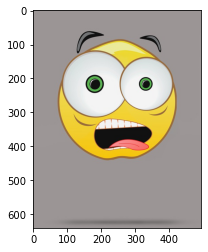

In [23]:
eye_img = cv2.imread(img_path + "/image.jpg")

plt.imshow(cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))
plt.show()

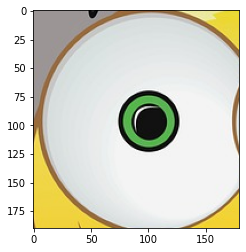

In [24]:
cropped_eye_img = eye_img[120:310, 80:260] # y축, x축

plt.imshow(cv2.cvtColor(cropped_eye_img, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
# x = int(repred[0][2][0])
# y = int(repred[0][2][1])
# w = 30
# h = 30

# print("(x, y) : (%d, %d)" % (x, y))
# print("(w, h) : (%d, %d)" % (w, h))

In [26]:
x = int(repred[0][2][0].round() * 0.6)
y = int(repred[0][2][1].round() * 0.6)
w = 30
h = 30

print("(x, y) : (%d, %d)" % (x, y))
print("(w, h) : (%d, %d)" % (w, h))

(x, y) : (32, 16)
(w, h) : (30, 30)


In [27]:
eye_img_sticker = cv2.resize(cropped_eye_img, (w, h))
print (eye_img_sticker.shape)

(30, 30, 3)


In [28]:
refined_x = x - w // 2 # left
refined_y = y - h // 2 # top
print ("(x, y) : (%d, %d)" % (refined_x, refined_y))

(x, y) : (17, 1)


In [29]:
eye_img_sticker = eye_img_sticker[refined_y:]
print (eye_img_sticker.shape)

(29, 30, 3)


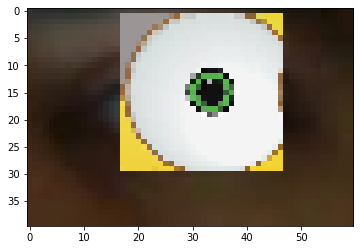

In [30]:
sticker_area = show[refined_y:refined_y + eye_img_sticker.shape[0], refined_x:refined_x + eye_img_sticker.shape[1]]

img[refined_y:refined_y + eye_img_sticker.shape[0], refined_x:refined_x + eye_img_sticker.shape[1]] = np.where(eye_img_sticker == 255, sticker_area, eye_img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 회고록

In [31]:
# 앞에 노드를 따라한 코드 진행에서 보면 다른 이미지를 바꿔서 모델 평가를 해봐도 눈을 제대로 찾은 걸 보지 못했다.
# 이런 이미지들을 가지고 프로젝트를 어떻게 해야하나....고민이 많았는데, 그 이전에 에디터에서 하던 것이 생각났다.
# 이미지를 비교하면 저 위에 찾지 못하는 이미지는 해상도가 많이 떨어지고 (사람 눈으로 봐도 먼지 모를 정도의 해상도도 있다)
# 프로젝트에 쓰인 이미지는 해상도가 비교적 좋았다.
# 그래서 이 이미지를 가지고 눈 위치를 찾기를 했는데 다른건 몰라도 눈 중앙의 위치는 찾았다.
# 그래서 이 이미지의 좌표를 따고, 합성할 이미지의 눈 한쪽 이미지 좌표를 따고, 그 두 개의 이미지를 잘 합성시켰다.
# 합성 시킬 때의 코드는 예전에 3번째 프로젝트를 할 때가 생각이 나서 그 코드를 참고했다. (참고인가 인용인가..)